# Imports :

In [3]:
# Skipping version problems :
! pip install --upgrade numpy

# Fixing non-readable DCIM images issue :

! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom

# To see metrics tracking during training :
! pip install livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 30.9 MB/s eta 0:00:0000:0100:01


In [16]:
!pip install classification-models-3D
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 998.4 kB/s eta 0:00:00 0:00:01


In [5]:
import os
import glob
import gc

import numpy as np
import pandas as pd
from scipy import ndimage

from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import pydicom as dicom
import gdcm

import tensorflow as tf
from tensorflow import keras
from livelossplot import PlotLossesKeras


# Defining useful paths :

In [6]:
# Where the preprocessed images (as numpy arrays) are :

PREPROCESSED_TRAIN_PATH = '../input/3d-conv-preparation/train_arrays'

# Where the non-preprocessed images are :
TRAIN_IMAGES_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/'
TEST_IMAGES_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test_images/'

# Pathes of the dataframes :
TRAIN_CSV_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train.csv'
TEST_CSV_PATH = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/test.csv'

# Defining useful features :

In [7]:
# Getting all arrays filenames (preprocessed images) :

train_images = os.listdir(PREPROCESSED_TRAIN_PATH)
train_images[:3]

['1.2.826.0.1.3680043.32046.npy',
 '1.2.826.0.1.3680043.5135.npy',
 '1.2.826.0.1.3680043.2896.npy']

In [9]:
# Reading dataframes :

train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

train_df

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2014,1.2.826.0.1.3680043.21684,1,0,1,0,0,0,1,1
2015,1.2.826.0.1.3680043.4786,1,0,0,0,0,0,0,1
2016,1.2.826.0.1.3680043.14341,0,0,0,0,0,0,0,0
2017,1.2.826.0.1.3680043.12053,0,0,0,0,0,0,0,0


# Train / Validation split :

In [10]:
# Train / Validation split :

from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(train_df, train_size=0.8, shuffle=True)

train_set

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
166,1.2.826.0.1.3680043.17346,1,0,0,0,0,0,1,1
1492,1.2.826.0.1.3680043.8548,0,0,0,0,0,0,0,0
1282,1.2.826.0.1.3680043.30765,0,0,0,0,0,0,0,0
1927,1.2.826.0.1.3680043.29924,0,0,0,0,0,0,0,0
58,1.2.826.0.1.3680043.31921,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
512,1.2.826.0.1.3680043.5957,1,0,0,0,0,1,0,0
382,1.2.826.0.1.3680043.10136,0,0,0,0,0,0,0,0
1509,1.2.826.0.1.3680043.3302,1,0,0,0,0,0,0,1
1308,1.2.826.0.1.3680043.7025,1,1,1,0,0,0,0,0


In [11]:
# Creation of the dictionary "partition" :

train_IDs = [x for x in train_set['StudyInstanceUID']]

print("Printing the first elements of train_IDs : ", train_IDs[:3])

val_IDs = [x for x in val_set['StudyInstanceUID']]

print("Printing the first elements of val_IDs : ", val_IDs[:3])

partition = {"train": train_IDs, "validation": val_IDs}

Printing the first elements of train_IDs :  ['1.2.826.0.1.3680043.17346', '1.2.826.0.1.3680043.8548', '1.2.826.0.1.3680043.30765']
Printing the first elements of val_IDs :  ['1.2.826.0.1.3680043.29047', '1.2.826.0.1.3680043.14348', '1.2.826.0.1.3680043.4216']


In [12]:
## Creation of the dictionary "labels" :

labels = {}

for i in train_df.index:
    list_of_values = [train_df["patient_overall"][i],
                      train_df["C1"][i],
                      train_df["C2"][i],
                      train_df["C3"][i],
                      train_df["C4"][i],
                      train_df["C5"][i],
                      train_df["C6"][i],
                      train_df["C7"][i]]
    UID = train_df["StudyInstanceUID"][i]
    labels[UID] = np.array(list_of_values)
    
labels

{'1.2.826.0.1.3680043.6200': array([1, 1, 1, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.27262': array([1, 0, 1, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.21561': array([1, 0, 1, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.12351': array([0, 0, 0, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.1363': array([1, 0, 0, 0, 0, 1, 0, 0]),
 '1.2.826.0.1.3680043.4859': array([1, 0, 0, 0, 0, 0, 1, 0]),
 '1.2.826.0.1.3680043.18659': array([1, 0, 0, 0, 1, 0, 0, 1]),
 '1.2.826.0.1.3680043.17364': array([0, 0, 0, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.849': array([0, 0, 0, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.24045': array([1, 0, 0, 0, 0, 0, 0, 1]),
 '1.2.826.0.1.3680043.4744': array([1, 0, 0, 0, 1, 1, 0, 0]),
 '1.2.826.0.1.3680043.15773': array([1, 1, 1, 0, 0, 0, 0, 1]),
 '1.2.826.0.1.3680043.24946': array([0, 0, 0, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.9290': array([0, 0, 0, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.5482': array([1, 1, 0, 0, 0, 0, 0, 0]),
 '1.2.826.0.1.3680043.11090': array([0, 0, 0, 0, 0, 0, 0, 0]),


# Creating generators :

In [13]:
# Creation of data generators. Source : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(64,64,64), n_channels=1,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, 8), dtype=int) # with 8 elements per label (C1, C2...)
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = np.load(os.path.join(PREPROCESSED_TRAIN_PATH, ID) + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [14]:
# Instanciating data generators :

params = {'dim': (64,64,64),
          'batch_size': 8,
          'n_channels': 1,
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Model creation :

In [ ]:
# Creating model :

def get_model(width=64, height=64, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='SAME')(inputs)
    x = keras.layers.MaxPool3D(pool_size=2, padding='SAME')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding='SAME')(x)
    x = keras.layers.MaxPool3D(pool_size=2, padding='SAME')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding='SAME')(x)
    x = keras.layers.MaxPool3D(pool_size=2, padding='SAME')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu", padding='SAME')(x)
    x = keras.layers.MaxPool3D(pool_size=2, padding='SAME')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(units=512, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)

    outputs = keras.layers.Dense(units=8, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=64, height=64, depth=64)
model.summary()

In [ ]:
# Defining checkpoints :

checkpoint_path = '3D_conv_64_64_64_a/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_3D_conv_64_64_64_a = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                   monitor='val_accuracy',
                                                                   verbose=1,
                                                                   save_best_only=True,
                                                                   mode='max')

plot_loss_cb_3D_conv_64_64_64_a = PlotLossesKeras()

early_stopping_cb_3D_conv_64_64_64_a = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                     patience=7,
                                                                     mode='auto',
                                                                     verbose=1,
                                                                     restore_best_weights=True)

In [ ]:
# Compile model :

model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       'AUC',
                       'accuracy'])


# Training the model :

In [ ]:
# Train the model for 10 epoch :
epochs = 100
model.fit(training_generator,
          validation_data=validation_generator,
          epochs=epochs,
          shuffle=True,
          verbose=1,
          callbacks=[checkpoint_cb_3D_conv_64_64_64_a, 
                     plot_loss_cb_3D_conv_64_64_64_a,
                     early_stopping_cb_3D_conv_64_64_64_a])

In [ ]:
# Testing its predictions on a few samples from the validation set :

for i in np.arange(0,len(val_IDs),10):
    scan_sample_path = os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[i]) + '.npy'
    sample_array = np.load(scan_sample_path)
    prediction = model.predict(sample_array)
    print("Index ", i)
    print("Prediction : ")
    print(prediction[0])
    print("Labels : ")
    ground_truth_labels = labels[val_IDs[i]]
    print(ground_truth_labels)
    print("")
    print("- "*30)
    print("")

Watching over the predictions this model make, we can conclude it is just giving the same outputs whatever the scan input is, and with the 'patient_overall' output at around 22%, the 'C2' output at 17% and every other very close to 0. 

We will now train the same model using a bigger batch_size too (32 instead of 8) :

In [ ]:
# Defining checkpoints :

checkpoint_path = '3D_conv_64_64_64_b/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_3D_conv_64_64_64_b = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                   monitor='val_accuracy',
                                                                   verbose=1,
                                                                   save_best_only=True,
                                                                   mode='max')

plot_loss_cb_3D_conv_64_64_64_b = PlotLossesKeras()

early_stopping_cb_3D_conv_64_64_64_b = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                     patience=9,
                                                                     mode='auto',
                                                                     verbose=1,
                                                                     restore_best_weights=True)

In [ ]:
# Instanciating data generators :

params = {'dim': (64,64,64),
          'batch_size': 32,
          'n_channels': 1,
          'shuffle': True}

training_generator_2 = DataGenerator(partition['train'], labels, **params)
validation_generator_2 = DataGenerator(partition['validation'], labels, **params)

In [ ]:
# Build model.
model_2 = get_model(width=64, height=64, depth=64)
model_2.summary()

In [ ]:
# Compile model :

model_2.compile(loss="binary_crossentropy", #competition_loss,
                optimizer=keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        'AUC',
                        'accuracy'])


In [ ]:
# Train the model for 10 epoch :
epochs = 100
model_2.fit(training_generator_2,
            validation_data=validation_generator_2,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_3D_conv_64_64_64_b, 
                       plot_loss_cb_3D_conv_64_64_64_b,
                       early_stopping_cb_3D_conv_64_64_64_b])

In [ ]:
# Testing its predictions on a few samples from the validation set :

for i in np.arange(0,len(val_IDs),40):
    scan_sample_path = os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[i]) + '.npy'
    sample_array = np.load(scan_sample_path)
    prediction = model_2.predict(sample_array)
    print("Index ", i)
    print("Prediction : ")
    print(prediction)
    print("Labels : ")
    ground_truth_labels = labels[val_IDs[i]]
    print(ground_truth_labels)
    print("")
    print("- "*30)
    print("")

Same conclusion : the model underfits the data.
Next iteration : trying a more complex model : a ResNet-50.

In [ ]:
# Creating a ResNet-50 model :

from classification_models_3D.tfkeras import Classifiers

model_arch = 'resnet50' 


def get_model_3(width=64, height=64, depth=64):
    inputs = keras.layers.Input((width, height, depth, 1), name='inputs')
    x = keras.layers.Rescaling(1/255.)(inputs)
    x = keras.layers.Conv3D(filters=3, 
                            kernel_size=(1, 1, 1), 
                            padding='same')(x)
    
    net, preprocess_input = Classifiers.get(model_arch)
    x = preprocess_input(x)
    x = net(input_shape=(width, height, depth, 3), include_top=False, weights='imagenet')(x)
    # with input shape corresponding to the output of the last layer
    
    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dropout(rate=0.1)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(rate=0.1)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(rate=0.1)(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    
    outputs = keras.layers.Dense(8, activation='sigmoid')(x)
    model  = tf.keras.Model(inputs, outputs)
   
    model.compile(loss="binary_crossentropy",
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          'AUC',
                          'accuracy'])
    return model

model_3 = get_model_3(64, 64, 64)

model_3.summary()

In [ ]:
# Defining checkpoints :

checkpoint_path = 'ResNet50_64_64_64_a/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_ResNet50_64_64_64_a = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    monitor='val_accuracy',
                                                                    verbose=1,
                                                                    save_best_only=True,
                                                                    mode='max')

plot_loss_cb_ResNet50_64_64_64_a = PlotLossesKeras()

early_stopping_cb_ResNet50_64_64_64_a = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      patience=9,
                                                                      mode='auto',
                                                                      verbose=1,
                                                                      restore_best_weights=True)

In [ ]:
# Train the model for 40 epoch :
epochs = 40
model_3.fit(training_generator_2,
            validation_data=validation_generator_2,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_ResNet50_64_64_64_a, 
                       plot_loss_cb_ResNet50_64_64_64_a,
                       early_stopping_cb_ResNet50_64_64_64_a])

In [ ]:
scan_sample_path = os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[19]) + '.npy'
sample_array = np.load(scan_sample_path)
sample_array.shape

In [ ]:
# Testing its predictions using a bacth sample :

sample_indexes = np.random.randint(0, len(val_IDs)-1, 8) # getting random indexes to take samples from the validation set
batch_x = np.empty((8, 64, 64, 64, 1))
for i_slice in range(0, 8):
    batch_x[i_slice,] = np.load(os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[sample_indexes[i_slice]])+'.npy')

predictions = model_3.predict(batch_x)
print(predictions)

# Transfer learning finer approach :

Retraining only the other layers :

In [ ]:
# Input base :

def get_model_4_base(width=64, height=64, depth=64):
    inputs = keras.layers.Input((width, height, depth, 1), name='inputs')
    x = keras.layers.Rescaling(1/255.)(inputs)
    outputs = keras.layers.Conv3D(filters=3, 
                                  kernel_size=(1, 1, 1), 
                                  padding='same')(x)

    model  = tf.keras.Model(inputs, outputs)
    
    return(model)

# Instanciating base model :
width = 64
height = 64
depth = 64

base_model_4 = get_model_4_base(width=width, height=height, depth=depth)

    
# Put Pretrained ResNet50 layers on top of the base model :

from classification_models_3D.tfkeras import Classifiers
model_arch = 'resnet50' 

net, preprocess_input = Classifiers.get(model_arch)

inputs_resnet50 = preprocess_input(base_model_4.output)
outputs_resnet50 = net(input_shape=(width, height, depth, 3), include_top=False, weights='imagenet')(inputs_resnet50)

resnet50_model = tf.keras.Model(inputs=base_model_4.input, outputs=outputs_resnet50)
    
# Freezing its layers weigth :
resnet50_model.trainable = False
    

# On-top MLP :

inputs_MLP = keras.layers.GlobalAveragePooling3D()(resnet50_model.output)
x = keras.layers.Dropout(rate=0.1)(inputs_MLP)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(32, activation='relu')(x)
    
outputs_MLP = keras.layers.Dense(8, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs=base_model_4.input, outputs=outputs_MLP)
   
model_4.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        'AUC',
                        'accuracy'])

model_4.summary()

In [ ]:
# Defining checkpoints :

checkpoint_path = 'ResNet50_64_64_64_b/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_ResNet50_64_64_64_b = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    monitor='val_accuracy',
                                                                    verbose=1,
                                                                    save_best_only=True,
                                                                    mode='max')

plot_loss_cb_ResNet50_64_64_64_b = PlotLossesKeras()

early_stopping_cb_ResNet50_64_64_64_b = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      patience=15,
                                                                      mode='auto',
                                                                      verbose=1,
                                                                      restore_best_weights=True)

In [ ]:
# Train the model for 100 epoch :
epochs = 100
model_4.fit(training_generator_2,
            validation_data=validation_generator_2,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_ResNet50_64_64_64_b, 
                       plot_loss_cb_ResNet50_64_64_64_b,
                       early_stopping_cb_ResNet50_64_64_64_b])

In [ ]:
# Testing its predictions using a bacth sample :

sample_indexes = np.random.randint(0, len(val_IDs)-1, 40) # getting random indexes to take samples from the validation set
batch_x = np.empty((40, 64, 64, 64, 1))
for i_slice in range(0, 40):
    batch_x[i_slice,] = np.load(os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[sample_indexes[i_slice]])+'.npy')

predictions = model_4.predict(batch_x)
print(predictions)

As the past models, this one is always predicting the same "probabilities" whatever the scan is : [0.44250354 0.05443189 0.13094024 0.02402152 0.04309094 0.07088165
  0.1182562  0.1611345 ]
  
Another observation we can make is that the first element (corresponding to 'patient_overall') is approximatively equal to the sum of the others probabilities : which is pretty meaningful, but this was learnt by the model on labels as we didn't give it this information.

In [ ]:
# Looking to find which is the proportion of 1 and 0 for each element of the labels in the training set to compare with the static results given :

for column_name in train_set.columns[1:]:
    proportion_of_1 = train_set[column_name].value_counts()[1] / train_set[column_name].value_counts().sum()
    print("Proportion of 1 in {column} : {proportion}".format(column = column_name, proportion = proportion_of_1))

This shows that this model is generalizing the global results : whatever the scan, it gives "probabilities" very close to the average of the whole training set for each element.

# Trying to implement a custom loss : the competition loss

In [ ]:
## Creating the competition loss function used for evaluation :

# Source : https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/341854#1884562

def competition_loss(y_true, y_pred):

    competition_weights = {
        '-' : tf.constant([7, 1, 1, 1, 1, 1, 1, 1], dtype=tf.float32),
        '+' : tf.constant([14, 2, 2, 2, 2, 2, 2, 2], dtype=tf.float32)
    }
    
    loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(tf.expand_dims(y_true, -1),tf.expand_dims(y_pred,-1))
    weights  = y_true*competition_weights['+'] + (1-y_true)*competition_weights['-'] 
    
    loss = tf.reduce_mean(tf.reduce_sum(loss * weights, axis=1)) / tf.reduce_sum(weights)
    return loss

In [ ]:
# Trying the competition loss :

print("labels[val_IDs[sample_indexes[4]]] : ", labels[val_IDs[sample_indexes[4]]])
print("predictions[4] : ", predictions[4])

competition_loss(predictions[10:], predictions[10:])

In [ ]:
# Input base :

def get_model_5_base(width=64, height=64, depth=64):
    inputs = keras.layers.Input((width, height, depth, 1), name='inputs')
    x = keras.layers.Rescaling(1/255.)(inputs)
    outputs = keras.layers.Conv3D(filters=3, 
                                  kernel_size=(1, 1, 1), 
                                  padding='same')(x)

    model  = tf.keras.Model(inputs, outputs)
    
    return(model)

# Instanciating base model :
width = 64
height = 64
depth = 64

base_model_5 = get_model_5_base(width=width, height=height, depth=depth)

    
# Put Pretrained ResNet50 layers on top of the base model :

from classification_models_3D.tfkeras import Classifiers
model_arch = 'resnet50' 

net, preprocess_input = Classifiers.get(model_arch)

inputs_resnet50 = preprocess_input(base_model_5.output)
outputs_resnet50 = net(input_shape=(width, height, depth, 3), include_top=False, weights='imagenet')(inputs_resnet50)

resnet50_model = tf.keras.Model(inputs=base_model_5.input, outputs=outputs_resnet50)
    
# Freezing its layers weigth :
resnet50_model.trainable = False
    

# On-top MLP :

inputs_MLP = keras.layers.GlobalAveragePooling3D()(resnet50_model.output)
x = keras.layers.Dropout(rate=0.1)(inputs_MLP)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(32, activation='relu')(x)
    
outputs_MLP = keras.layers.Dense(8, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs=base_model_5.input, outputs=outputs_MLP)
   
model_5.compile(loss=competition_loss,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        'AUC',
                        'accuracy'])

model_5.summary()

In [ ]:
# Defining checkpoints :

checkpoint_path = 'ResNet50_64_64_64_c/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_ResNet50_64_64_64_c = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    monitor='val_accuracy',
                                                                    verbose=1,
                                                                    save_best_only=True,
                                                                    mode='max')

plot_loss_cb_ResNet50_64_64_64_c = PlotLossesKeras()

early_stopping_cb_ResNet50_64_64_64_c = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      patience=15,
                                                                      mode='auto',
                                                                      verbose=1,
                                                                      restore_best_weights=True)

In [ ]:
# (re-)Creation of generator to fix an incompatibility issue with type of elements in arrays :


class DataGenerator_2(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(64,64,64), n_channels=1,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, 8), dtype=int) # with 8 elements per label (C1, C2...)
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = np.load(os.path.join(PREPROCESSED_TRAIN_PATH, ID) + '.npy').astype(np.float32)

            # Store class
            y[i] = self.labels[ID].astype(np.float32)

        return X.astype(np.float32), y.astype(np.float32)

In [ ]:
# Instanciating new data generators :

params = {'dim': (64,64,64),
          'batch_size': 8,
          'n_channels': 1,
          'shuffle': True}

training_generator_3 = DataGenerator_2(partition['train'], labels, **params)
validation_generator_3 = DataGenerator_2(partition['validation'], labels, **params)

In [ ]:
# Train the model for 100 epoch :
tf.config.run_functions_eagerly(True)

epochs = 100
model_5.fit(training_generator_3,
            validation_data=validation_generator_3,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_ResNet50_64_64_64_c, 
                       plot_loss_cb_ResNet50_64_64_64_c,
                       early_stopping_cb_ResNet50_64_64_64_c])

In [ ]:
# Testing its predictions using a bacth sample :

sample_indexes = np.random.randint(0, len(val_IDs)-1, 40) # getting random indexes to take samples from the validation set
batch_x = np.empty((40, 64, 64, 64, 1))
for i_slice in range(0, 40):
    batch_x[i_slice,] = np.load(os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[sample_indexes[i_slice]])+'.npy')

predictions = model_5.predict(batch_x)
print(predictions)

# Trying to improve learning :

#1 : Learning rate tuning

#1.1 : trying lower values for the learning rate

In [ ]:
# Input base :

def get_model_5_base(width=64, height=64, depth=64):
    inputs = keras.layers.Input((width, height, depth, 1), name='inputs')
    x = keras.layers.Rescaling(1/255.)(inputs)
    outputs = keras.layers.Conv3D(filters=3, 
                                  kernel_size=(1, 1, 1), 
                                  padding='same')(x)

    model  = tf.keras.Model(inputs, outputs)
    
    return(model)

# Instanciating base model :
width = 64
height = 64
depth = 64

base_model_5 = get_model_5_base(width=width, height=height, depth=depth)

    
# Put Pretrained ResNet50 layers on top of the base model :

from classification_models_3D.tfkeras import Classifiers
model_arch = 'resnet50' 

net, preprocess_input = Classifiers.get(model_arch)

inputs_resnet50 = preprocess_input(base_model_5.output)
outputs_resnet50 = net(input_shape=(width, height, depth, 3), include_top=False, weights='imagenet')(inputs_resnet50)

resnet50_model = tf.keras.Model(inputs=base_model_5.input, outputs=outputs_resnet50)
    
# Freezing its layers weigth :
resnet50_model.trainable = False
    

# On-top MLP :

inputs_MLP = keras.layers.GlobalAveragePooling3D()(resnet50_model.output)
x = keras.layers.Dropout(rate=0.1)(inputs_MLP)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(32, activation='relu')(x)
    
outputs_MLP = keras.layers.Dense(8, activation='sigmoid')(x)
model_6 = tf.keras.Model(inputs=base_model_5.input, outputs=outputs_MLP)
   
model_6.compile(loss=competition_loss,
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        'AUC',
                        'accuracy'])

model_6.summary()

In [ ]:
# Defining checkpoints :

checkpoint_path = 'ResNet50_64_64_64_d/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_ResNet50_64_64_64_d = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    monitor='val_accuracy',
                                                                    verbose=1,
                                                                    save_best_only=True,
                                                                    mode='max')

plot_loss_cb_ResNet50_64_64_64_d = PlotLossesKeras()

early_stopping_cb_ResNet50_64_64_64_d = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      patience=15,
                                                                      mode='auto',
                                                                      verbose=1,
                                                                      restore_best_weights=True)

In [ ]:
# Train the model for 100 epoch :
tf.config.run_functions_eagerly(True)

epochs = 100
model_6.fit(training_generator_3,
            validation_data=validation_generator_3,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_ResNet50_64_64_64_d, 
                       plot_loss_cb_ResNet50_64_64_64_d,
                       early_stopping_cb_ResNet50_64_64_64_d])

In [ ]:
# Testing its predictions using a bacth sample :

sample_indexes = np.random.randint(0, len(val_IDs)-1, 40) # getting random indexes to take samples from the validation set
batch_x = np.empty((40, 64, 64, 64, 1))
for i_slice in range(0, 40):
    batch_x[i_slice,] = np.load(os.path.join(PREPROCESSED_TRAIN_PATH, val_IDs[sample_indexes[i_slice]])+'.npy')

predictions = model_6.predict(batch_x)
print(predictions)

In [ ]:
# Saving trained model :

model_6.save("ResNet50-d-64x64x64")

# Trying the same model on another preprocessed dataset : with interpolation of order 3 on width and height of each slice

In [24]:
# Where the preprocessed images (as numpy arrays) are :

NEW_PREPROCESSED_TRAIN_PATH = '../input/3dconv64x64x64interpolorder3widthandheight/train_arrays'

In [20]:
# Generator using the new preprocessed data :


class DataGenerator_3(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(64,64,64), n_channels=1,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, 8), dtype=int) # with 8 elements per label (C1, C2...)
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')
            X[i,] = np.load(os.path.join(NEW_PREPROCESSED_TRAIN_PATH, ID) + '.npy').astype(np.float32)

            # Store class
            y[i] = self.labels[ID].astype(np.float32)

        return X.astype(np.float32), y.astype(np.float32)

In [32]:
# Instanciating new data generators :

params = {'dim': (64,64,64),
          'batch_size': 64,
          'n_channels': 1,
          'shuffle': True}

training_generator_4 = DataGenerator_3(partition['train'], labels, **params)
validation_generator_4 = DataGenerator_3(partition['validation'], labels, **params)

In [ ]:
## Creation of the new model :

# Input base :

def get_model_5_base(width=64, height=64, depth=64):
    inputs = keras.layers.Input((width, height, depth, 1), name='inputs')
    x = keras.layers.Rescaling(1/255.)(inputs)
    outputs = keras.layers.Conv3D(filters=3, 
                                  kernel_size=(1, 1, 1), 
                                  padding='same')(x)

    model  = tf.keras.Model(inputs, outputs)
    
    return(model)

# Instanciating base model :
width = 64
height = 64
depth = 64

base_model_5 = get_model_5_base(width=width, height=height, depth=depth)

    
# Put Pretrained ResNet50 layers on top of the base model :

from classification_models_3D.tfkeras import Classifiers
model_arch = 'resnet50' 

net, preprocess_input = Classifiers.get(model_arch)

inputs_resnet50 = preprocess_input(base_model_5.output)
outputs_resnet50 = net(input_shape=(width, height, depth, 3), include_top=False, weights='imagenet')(inputs_resnet50)

resnet50_model = tf.keras.Model(inputs=base_model_5.input, outputs=outputs_resnet50)
    
# Freezing its layers weigth :
resnet50_model.trainable = False
    

# On-top MLP :

inputs_MLP = keras.layers.GlobalAveragePooling3D()(resnet50_model.output)
x = keras.layers.Dropout(rate=0.1)(inputs_MLP)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(32, activation='relu')(x)
    
outputs_MLP = keras.layers.Dense(8, activation='sigmoid')(x)
model_7 = tf.keras.Model(inputs=base_model_5.input, outputs=outputs_MLP)
   
model_7.compile(loss=competition_loss,
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        'AUC',
                        'accuracy'])

model_7.summary()

In [ ]:
# Defining checkpoints :

checkpoint_path = 'ResNet50_64_64_64_e/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_ResNet50_64_64_64_e = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                    monitor='val_accuracy',
                                                                    verbose=1,
                                                                    save_best_only=True,
                                                                    mode='max')

plot_loss_cb_ResNet50_64_64_64_e = PlotLossesKeras()

early_stopping_cb_ResNet50_64_64_64_e = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      patience=10,
                                                                      mode='auto',
                                                                      verbose=1,
                                                                      restore_best_weights=True)

In [ ]:
# Train the model for 100 epoch :
tf.config.run_functions_eagerly(True)

epochs = 100
model_7.fit(training_generator_4,
            validation_data=validation_generator_4,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_ResNet50_64_64_64_e, 
                       plot_loss_cb_ResNet50_64_64_64_e,
                       early_stopping_cb_ResNet50_64_64_64_e])

In [ ]:
# Testing its predictions using a bacth sample :

sample_indexes = np.random.randint(0, len(val_IDs)-1, 40) # getting random indexes to take samples from the validation set
batch_x = np.empty((40, 64, 64, 64, 1))
for i_slice in range(0, 40):
    batch_x[i_slice,] = np.load(os.path.join(NEW_PREPROCESSED_TRAIN_PATH, val_IDs[sample_indexes[i_slice]])+'.npy')

predictions = model_7.predict(batch_x)
print(predictions)

In [ ]:
# Saving trained model :

model_7.save("ResNet50-e-64x64x64")

# Inception V3 + deleting rescaling part on the base model :

In [27]:
## Creation of the new model :

# Input base :

def get_model_base(width=64, height=64, depth=64):
    inputs = keras.layers.Input((width, height, depth, 1), name='inputs')
    outputs = keras.layers.Conv3D(filters=3, 
                                  kernel_size=(1, 1, 1), 
                                  padding='same')(inputs)

    model  = tf.keras.Model(inputs, outputs)
    
    return(model)

# Instanciating base model :
width = 64
height = 64
depth = 64

base_model = get_model_base(width=width, height=height, depth=depth)

    
# Put Pretrained Inception V3 layers on top of the base model :

from classification_models_3D.tfkeras import Classifiers
model_arch = 'inceptionv3' 

net, preprocess_input = Classifiers.get(model_arch)

inputs_pretrained_model = preprocess_input(base_model.output)
outputs_pretrained_model = net(input_shape=(width, height, depth, 3), include_top=False, weights='imagenet')(inputs_pretrained_model)

pretrained_model = tf.keras.Model(inputs=base_model.input, outputs=outputs_pretrained_model)
    
# Freezing its layers weigth :
pretrained_model.trainable = False
    

# On-top MLP :

inputs_MLP = keras.layers.GlobalAveragePooling3D()(pretrained_model.output)
x = keras.layers.Dropout(rate=0.1)(inputs_MLP)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.Dense(32, activation='relu')(x)
    
outputs_MLP = keras.layers.Dense(8, activation='sigmoid')(x)
model_8 = tf.keras.Model(inputs=base_model.input, outputs=outputs_MLP)
   
model_8.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                metrics=[tf.keras.metrics.BinaryAccuracy(),
                        'AUC',
                        'accuracy'])

model_8.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 64, 64, 64, 1)]   0         
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 64, 64, 64, 3)     6         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 64, 64, 64, 3)     0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 64, 64, 64, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2, 2048)     34117088  
_________________________________________________________________
global_average_pooling3d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0   

In [28]:
# Defining checkpoints :

checkpoint_path = 'InceptionV3_64_64_64_a/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


checkpoint_cb_InceptionV3_64_64_64_a = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                       monitor='val_accuracy',
                                                                       verbose=1,
                                                                       save_best_only=True,
                                                                       mode='max')

plot_loss_cb_InceptionV3_64_64_64_a = PlotLossesKeras()

early_stopping_cb_InceptionV3_64_64_64_a = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                         patience=10,
                                                                         mode='auto',
                                                                         verbose=1,
                                                                         restore_best_weights=True)

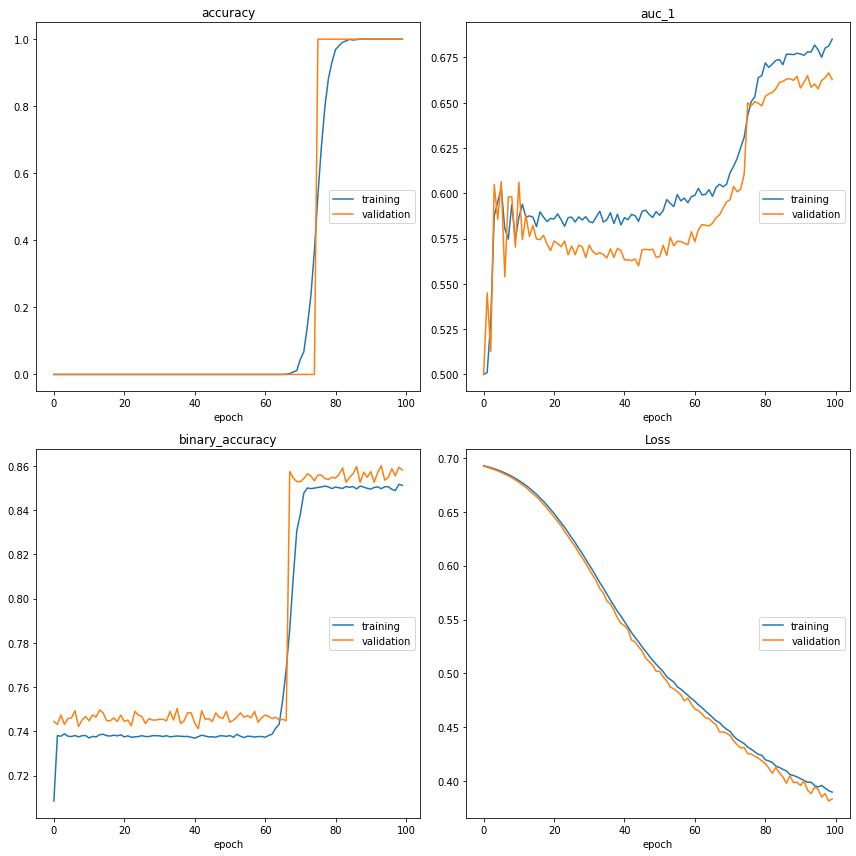

accuracy
	training         	 (min:    0.000, max:    1.000, cur:    1.000)
	validation       	 (min:    0.000, max:    1.000, cur:    1.000)
auc_1
	training         	 (min:    0.500, max:    0.685, cur:    0.685)
	validation       	 (min:    0.500, max:    0.666, cur:    0.663)
binary_accuracy
	training         	 (min:    0.709, max:    0.852, cur:    0.851)
	validation       	 (min:    0.741, max:    0.860, cur:    0.858)
Loss
	training         	 (min:    0.390, max:    0.693, cur:    0.390)
	validation       	 (min:    0.381, max:    0.692, cur:    0.384)


In [33]:
# Train the model for 100 epoch :
tf.config.run_functions_eagerly(True)

epochs = 100
model_8.fit(training_generator_4,
            validation_data=validation_generator_4,
            epochs=epochs,
            shuffle=True,
            verbose=1,
            callbacks=[checkpoint_cb_InceptionV3_64_64_64_a, 
                       plot_loss_cb_InceptionV3_64_64_64_a,
                       early_stopping_cb_InceptionV3_64_64_64_a])

In [34]:
# Testing its predictions using a bacth sample :

sample_indexes = np.random.randint(0, len(val_IDs)-1, 40) # getting random indexes to take samples from the validation set
batch_x = np.empty((40, 64, 64, 64, 1))
for i_slice in range(0, 40):
    batch_x[i_slice,] = np.load(os.path.join(NEW_PREPROCESSED_TRAIN_PATH, val_IDs[sample_indexes[i_slice]])+'.npy')

predictions = model_8.predict(batch_x)
print(predictions)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[0.45024934 0.04213164 0.17215945 0.13283162 0.2421374  0.1196873
  0.10740017 0.21652876]
 [0.4495417  0.04050159 0.16926436 0.1300137  0.23947987 0.11694904
  0.10475887 0.21365725]
 [0.44952387 0.04046604 0.1692015  0.129952   0.2394201  0.11688814
  0.10470098 0.21359529]
 [0.45081875 0.0435104  0.17455587 0.13516894 0.24433558 0.12196417
  0.10959942 0.21888931]
 [0.4497722  0.04102822 0.17020898 0.13093133 0.24034564 0.11783898
  0.10561771 0.21459584]
 [0.45044962 0.0426097  0.17299524 0.13364613 0.2429081  0.12048273
  0.10816551 0.21735105]
 [0.45013762 0.04187141 0.17170091 0.13238488 0.2417174  0.11925261
  0.10698077 0.21607547]
 [0.45044237 0.04259001 0.17295615 0.13361205 0.24287382 0.12044703
  0.10813352 0.21731816]
 [0.45014274 0.04188137 0.17171764 0.13240162 0.24173498 0.11926983
  0.10699637 0.21609081]
 [0.45117798 0.04437467 0.17602731 0.13661867 0.24567506 0.12337756
  0.11096577 0.22034712]
 [0.45157883 0.04537996 0.17772599 0.1382854  0.24721633 0.12500285
  0

In [35]:
# Saving trained model :

model_8.save("InceptionV3-b-64x64x64")